In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("Financial_Records.csv")

In [3]:
df["default"] = df["default"].map({1: 0, 2: 1})  # 0 = good, 1 = bad

In [4]:
df.head()

,PID,age,sex,marital_status,job,employment_since,credit_hist,credit_amount,purpose,duration,...,housing,existing_credits,liable_people,monthly_rent_or_mortgage,tel,online_banking,foreign,checking_account,savings,default
0,406827,33,male,single,unskilled - resident,3,delay,7378,radio/television,24,...,own,2,1,200,registered,yes,no,124,17,0
1,13257437,39,female,single,unskilled - resident,<1 year,existing credits paid,3331,car (new),30,...,own,2,1,204,registered,yes,yes,486,21,1
2,14303477,54,male,divorced/separated,management/self-employed/highly qualified,2,delay,804,car (new),61,...,own,1,1,187,none,yes,yes,132,229,0
3,16201589,54,female,single,management/self-employed/highly qualified,4,existing credits paid,1818,furniture/equipment,14,...,own,1,1,205,none,no,yes,176,45,0
4,11855923,59,male,single,skilled employee / official,3,critical account,4670,car (new),27,...,own,1,1,317,none,yes,yes,88,74,1


In [52]:
def bucket_savings(val):
    try:
        val = val.strip().lower()
        if val in ['unknown', '0']:
            return 'none_or_unknown'
        val_float = float(val)
        if val_float <= 100:
            return 'low'
        elif val_float <= 500:
            return 'medium'
        else:
            return 'high'
    except:
        return 'none_or_unknown'

def bucket_checking_account(val):
    try:
        val = val.strip().lower()
        if 'no checking' in val:
            return 'none'
        val_float = float(val)
        if val_float <= 100:
            return 'low'
        elif val_float <= 500:
            return 'medium'
        else:
            return 'high'
    except:
        return 'none'

def bucket_employment_since(val):
    val = str(val).strip().lower()
    if val == 'unemployed':
        return 'unemployed'
    if val == '<1 year' or val in ['1', '2', '3', '4']:
        return 'short'
    elif val in ['5', '6', '7']:
        return 'medium'
    else:
        return 'long'

df['savings_bucket'] = df['savings'].apply(bucket_savings)
df['checking_account_bucket'] = df['checking_account'].apply(bucket_checking_account)
df['employment_since_bucket'] = df['employment_since'].apply(bucket_employment_since)

df.drop(columns=['savings', 'checking_account', 'employment_since'], inplace=True)

In [53]:
df.head()

,PID,age,sex,marital_status,job,credit_hist,credit_amount,purpose,duration,installment_rate,...,existing_credits,liable_people,monthly_rent_or_mortgage,tel,online_banking,foreign,default,savings_bucket,checking_account_bucket,employment_since_bucket
0,406827,33,male,single,unskilled - resident,delay,7378,radio/television,24,4,...,2,1,200,registered,yes,no,0,low,medium,short
1,13257437,39,female,single,unskilled - resident,existing credits paid,3331,car (new),30,3,...,2,1,204,registered,yes,yes,1,low,medium,short
2,14303477,54,male,divorced/separated,management/self-employed/highly qualified,delay,804,car (new),61,4,...,1,1,187,none,yes,yes,0,medium,medium,short
3,16201589,54,female,single,management/self-employed/highly qualified,existing credits paid,1818,furniture/equipment,14,4,...,1,1,205,none,no,yes,0,low,medium,short
4,11855923,59,male,single,skilled employee / official,critical account,4670,car (new),27,4,...,1,1,317,none,yes,yes,1,low,low,short


In [26]:
len(df["job"].unique())

4

In [54]:
def bucket_monthly_rent(val):
    if val == 0:
        return 'none'
    elif val <= 200:
        return 'low'
    elif val <= 400:
        return 'medium'
    else:
        return 'high'

def bucket_credit_amount(val):
    if val <= 1000:
        return 'very_low'
    elif val <= 3000:
        return 'low'
    elif val <= 6000:
        return 'medium'
    else:
        return 'high'

def bucket_duration(val):
    if val <= 12:
        return 'short'
    elif val <= 24:
        return 'medium'
    elif val <= 48:
        return 'long'
    else:
        return 'very_long'

def bucket_age(val):
    if val <= 25:
        return 'young'
    elif val <= 40:
        return 'adult'
    elif val <= 60:
        return 'mature'
    else:
        return 'senior'

df['monthly_rent_bucket'] = df['monthly_rent_or_mortgage'].apply(bucket_monthly_rent)
df['credit_amount_bucket'] = df['credit_amount'].apply(bucket_credit_amount)
df['duration_bucket'] = df['duration'].apply(bucket_duration)
df['age_bucket'] = df['age'].apply(bucket_age)

df.drop(columns=['monthly_rent_or_mortgage', 'credit_amount', 'duration', 'age'], inplace=True)

In [55]:
df.head()

,PID,sex,marital_status,job,credit_hist,purpose,installment_rate,debtors,residence_since,property,...,online_banking,foreign,default,savings_bucket,checking_account_bucket,employment_since_bucket,monthly_rent_bucket,credit_amount_bucket,duration_bucket,age_bucket
0,406827,male,single,unskilled - resident,delay,radio/television,4,guarantor,4,unknown /no property,...,yes,no,0,low,medium,short,low,high,medium,adult
1,13257437,female,single,unskilled - resident,existing credits paid,car (new),3,none,4,life insurance,...,yes,yes,1,low,medium,short,medium,medium,long,adult
2,14303477,male,divorced/separated,management/self-employed/highly qualified,delay,car (new),4,none,3,life insurance,...,yes,yes,0,medium,medium,short,low,very_low,very_long,mature
3,16201589,female,single,management/self-employed/highly qualified,existing credits paid,furniture/equipment,4,none,4,unknown /no property,...,no,yes,0,low,medium,short,medium,low,medium,mature
4,11855923,male,single,skilled employee / official,critical account,car (new),4,none,1,car or other,...,yes,yes,1,low,low,short,medium,medium,long,mature


In [56]:
df.drop("PID", axis=1, inplace=True)

In [57]:
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = df.select_dtypes(include='object').columns.tolist()

encoder = OrdinalEncoder(dtype=int)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]) + 1

In [58]:
df.head()

,sex,marital_status,job,credit_hist,purpose,installment_rate,debtors,residence_since,property,installment_other,...,online_banking,foreign,default,savings_bucket,checking_account_bucket,employment_since_bucket,monthly_rent_bucket,credit_amount_bucket,duration_bucket,age_bucket
0,2,3,4,3,8,4,2,4,4,2,...,2,1,0,2,3,3,2,1,2,1
1,1,3,4,4,2,3,3,4,2,2,...,2,2,1,2,3,3,3,3,1,1
2,2,1,1,3,2,4,3,3,2,2,...,2,2,0,3,3,3,2,4,4,2
3,1,3,1,4,6,4,3,4,4,2,...,1,2,0,2,3,3,3,2,2,2
4,2,3,2,2,2,4,3,1,1,2,...,2,2,1,2,2,3,3,3,1,2


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=['default'])  # All columns except target
y = df['default']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3418 3426]
 [3263 3893]]
              precision    recall  f1-score   support

         0.0       0.51      0.50      0.51      6844
         1.0       0.53      0.54      0.54      7156

    accuracy                           0.52     14000
   macro avg       0.52      0.52      0.52     14000
weighted avg       0.52      0.52      0.52     14000



In [68]:
df.head()

,sex,marital_status,job,credit_hist,purpose,installment_rate,debtors,residence_since,property,installment_other,...,online_banking,foreign,default,savings_bucket,checking_account_bucket,employment_since_bucket,monthly_rent_bucket,credit_amount_bucket,duration_bucket,age_bucket
0,2,3,4,3,8,4,2,4,4,2,...,2,1,0,2,3,3,2,1,2,1
1,1,3,4,4,2,3,3,4,2,2,...,2,2,1,2,3,3,3,3,1,1
2,2,1,1,3,2,4,3,3,2,2,...,2,2,0,3,3,3,2,4,4,2
3,1,3,1,4,6,4,3,4,4,2,...,1,2,0,2,3,3,3,2,2,2
4,2,3,2,2,2,4,3,1,1,2,...,2,2,1,2,2,3,3,3,1,2


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Step 1: Split the data
X = df.drop(columns=["default"]).values.astype('float32')
y = (df["default"]).values.astype('float32')  # convert to 0 and 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

# Step 2: Define the model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.out(x))
        return x

model = Net(X.shape[1])

# Step 3: Set up training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 2000

# Step 4: Train the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Step 5: Evaluate
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).round().numpy()
    print(classification_report(y_test, predictions))


Epoch 1, Loss: 0.7148
Epoch 2, Loss: 0.7117
Epoch 3, Loss: 0.7084
Epoch 4, Loss: 0.7061
Epoch 5, Loss: 0.7045
Epoch 6, Loss: 0.7033
Epoch 7, Loss: 0.7014
Epoch 8, Loss: 0.7021
Epoch 9, Loss: 0.7000
Epoch 10, Loss: 0.6985
Epoch 11, Loss: 0.6994
Epoch 12, Loss: 0.6976
Epoch 13, Loss: 0.6977
Epoch 14, Loss: 0.6979
Epoch 15, Loss: 0.6981
Epoch 16, Loss: 0.6979
Epoch 17, Loss: 0.6978
Epoch 18, Loss: 0.6969
Epoch 19, Loss: 0.6966
Epoch 20, Loss: 0.6964
Epoch 21, Loss: 0.6959
Epoch 22, Loss: 0.6964
Epoch 23, Loss: 0.6962
Epoch 24, Loss: 0.6951
Epoch 25, Loss: 0.6957
Epoch 26, Loss: 0.6957
Epoch 27, Loss: 0.6955
Epoch 28, Loss: 0.6944
Epoch 29, Loss: 0.6946
Epoch 30, Loss: 0.6947
Epoch 31, Loss: 0.6948
Epoch 32, Loss: 0.6945
Epoch 33, Loss: 0.6942
Epoch 34, Loss: 0.6944
Epoch 35, Loss: 0.6942
Epoch 36, Loss: 0.6941
Epoch 37, Loss: 0.6939
Epoch 38, Loss: 0.6943
Epoch 39, Loss: 0.6939
Epoch 40, Loss: 0.6937
Epoch 41, Loss: 0.6935
Epoch 42, Loss: 0.6939
Epoch 43, Loss: 0.6939
Epoch 44, Loss: 0.69

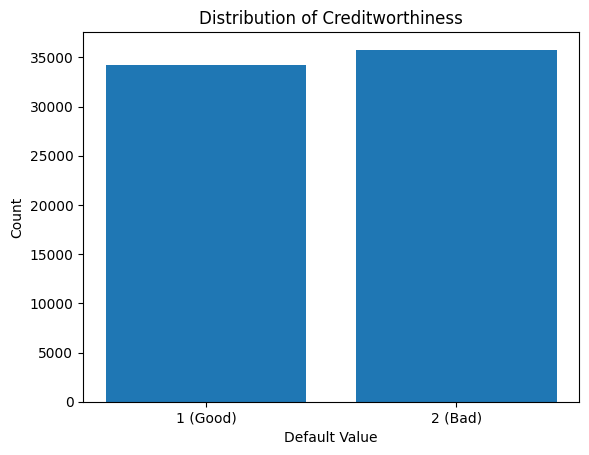

In [74]:
import matplotlib.pyplot as plt

# Count values
value_counts = df['default'].value_counts().sort_index()

# Plot
plt.bar(value_counts.index, value_counts.values, tick_label=["1 (Good)", "2 (Bad)"])
plt.title("Distribution of Creditworthiness")
plt.xlabel("Default Value")
plt.ylabel("Count")
plt.show()

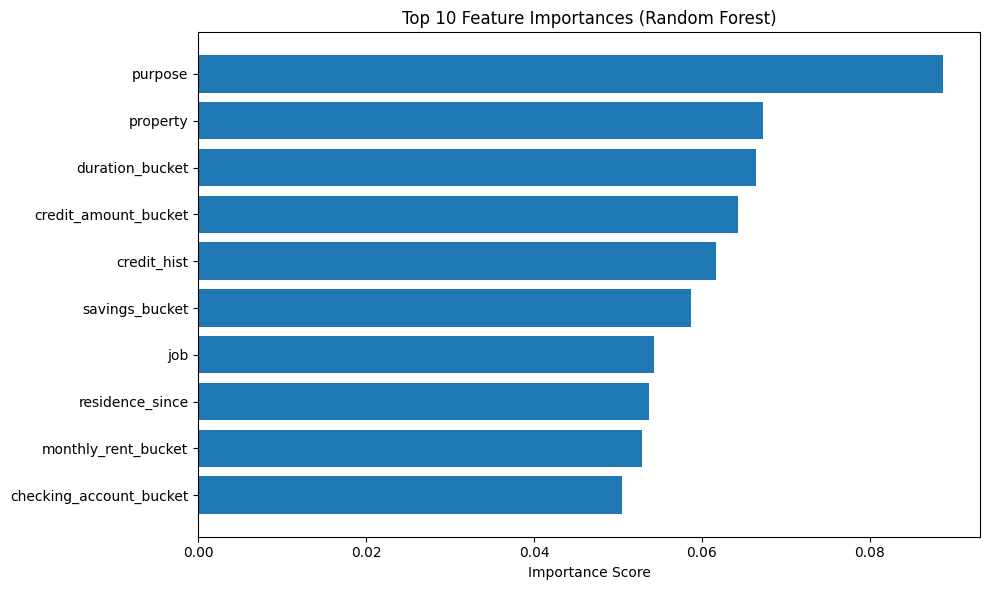

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming your feature names are from df (excluding the target)
feature_names = df.drop(columns=["default"]).columns

# Get feature importances from the trained model
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # descending order

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(10), importances[indices[:10]][::-1], align="center")
plt.yticks(range(10), [feature_names[i] for i in indices[:10]][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
